In [1]:
import pandas as pd
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from datetime import datetime
import random

import sys

from dateutil.parser import parse
from matplotlib import dates

from sklearn import preprocessing, neighbors, linear_model, model_selection, ensemble

In [2]:
d = pd.read_csv('../data/2016_subset_all_tables.csv', index_col = 0)

In [3]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype
id,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday


In [4]:
d['date_as_datetime'] = [parse(x) for x in d['date']]
d['date_as_num'] = [dates.date2num(x) for x in d['date_as_datetime']]

In [5]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype,date_as_datetime,date_as_num
id,,,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday,2016-02-22,736016.0
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday,2016-06-14,736129.0
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday,2016-10-04,736241.0
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0


In [6]:
d = d.join(pd.get_dummies(d['family'], prefix = 'family'))
d = d.join(pd.get_dummies(d['type'], prefix = 'type'))
d = d.join(pd.get_dummies(d['city'], prefix = 'city'))
d = d.join(pd.get_dummies(d['holitype'], prefix = 'holitype'))

In [7]:
d = d.dropna()

In [8]:
v_train, v_test = model_selection.train_test_split(d, test_size = 0.25)

In [9]:
v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])

print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0543199883553


In [10]:
knn = neighbors.KNeighborsRegressor()

knn_param_grid = [
    {'n_neighbors': range(1,200, 10)}
]

knn_grid = model_selection.GridSearchCV(knn, param_grid = knn_param_grid)
knn_grid.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(knn_grid.cv_results_['split0_test_score'])
print(knn_grid.cv_results_['split1_test_score'])
print(knn_grid.cv_results_['split2_test_score'])

[ -3.11541453e+00  -1.31350639e-01  -3.22547469e-02  -2.45190352e-02
  -1.71727255e-02  -2.39468217e-02  -4.63219001e-03  -2.53733022e-04
   4.01732100e-03   8.88332336e-03   1.39571513e-02   1.25266290e-02
   1.20885826e-02   1.50273056e-02   1.58907732e-02   1.66193718e-02
   1.84112358e-02   1.87312793e-02   1.76065287e-02   1.88462854e-02]
[-0.18425602 -0.01261413  0.01395321  0.0475413   0.03875041  0.03945202
  0.03502822  0.03206176  0.03060998  0.03100981  0.03029816  0.02859598
  0.02819052  0.02788254  0.02700116  0.0258452   0.02537602  0.02562899
  0.0257373   0.02610299]
[-1.67450879 -0.07295276 -0.04202912  0.03096643  0.03068195  0.03220809
  0.02285318  0.0293928   0.03530113  0.03391191  0.0349604   0.0358115
  0.03648696  0.03621666  0.03483657  0.03511892  0.03570716  0.03530716
  0.03418021  0.03532773]


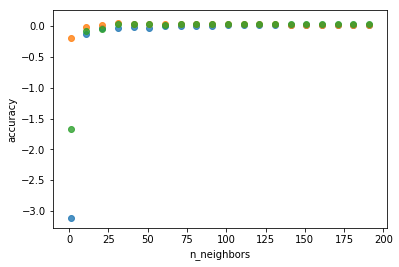

In [11]:

sp0 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split0_test_score'], fit_reg = False, label = 'split0').set(xlabel = 'n_neighbors', ylabel = 'accuracy')
sp1 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split1_test_score'], fit_reg = False, label = 'split1')
sp2 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split2_test_score'], fit_reg = False, label = 'split2')

plt.show()


In [12]:
knn_200 = neighbors.KNeighborsRegressor(n_neighbors = 200)
knn_200.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
knn_200.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.026808146877675632

In [13]:
rf = ensemble.RandomForestRegressor()
rf.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
rf.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


-0.029690131007828136

In [14]:
#ugghhhh the huge number of one-hot columns is causing me troubles!
#maybe it's time to switch to H2O!

#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
   #     'city_Ambato', 'city_Babahoyo',
    #   'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
     #  'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
     #  'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
      # 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       #'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_city_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0500518038934


In [15]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
     #  'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
     #  'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
     #  'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
     #  'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
     #  'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
     #  'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
     #  'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
     #  'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
     #  'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
     #  'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
     #  'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_family_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0464191187684


In [16]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
    #    'type_A',
    #   'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_type_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0527865644515


In [17]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo'
       #         ,
      # 'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
     #  'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer'
               ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_holi_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0580994249987


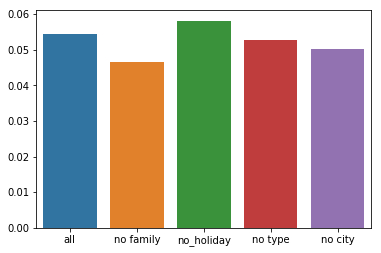

In [18]:
sns.barplot(['all', 'no family', 'no_holiday', 'no type', 'no city'], 
            [all_lin, no_family_lin, no_holi_lin, no_type_lin, no_city_lin])

In [19]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
fam_all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.052023351308


In [20]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        #'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_oil_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0520483948646


In [21]:
v_train_cols = [
        'onpromotion', 
        #'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_perish_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.052027112529


In [22]:
v_train_cols = [
        #'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_promo_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-6.64577526869e+15


In [23]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       #'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_trans_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-3.26401714102e+15


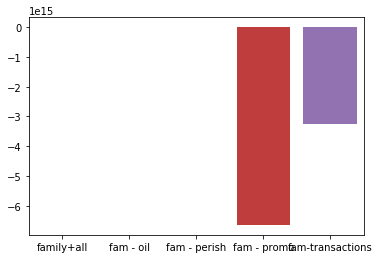

In [24]:
sns.barplot(['family+all', 'fam - oil', 'fam - perish', 'fam - promo', 'fam-transactions'], 
            [fam_all_lin, no_oil_lin, no_perish_lin, no_promo_lin, no_trans_lin])

In [25]:
v_train_cols = [
        'onpromotion', 
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
promo_trans_fam_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0520521652587


In [27]:
test = dd.read_csv('../data/raw/test.csv')
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [28]:
items = dd.read_csv('../data/raw/' + 'items.csv')
stores = dd.read_csv('../data/raw/' + 'stores.csv')
transactions = dd.read_csv('../data/raw/' + 'transactions.csv')

In [29]:
test = test.merge(items)
print(test.head())
test = test.drop(['date','item_nbr', 'class', 'perishable'], axis = 1).compute()
print(test.head())

          id        date  store_nbr  item_nbr  onpromotion     family  class  \
0  125497040  2017-08-16          1     96995        False  GROCERY I   1093   
1  125500941  2017-08-16          2     96995        False  GROCERY I   1093   
2  125504842  2017-08-16          3     96995        False  GROCERY I   1093   
3  125508743  2017-08-16          4     96995        False  GROCERY I   1093   
4  125512644  2017-08-16          5     96995        False  GROCERY I   1093   

   perishable  
0           0  
1           0  
2           0  
3           0  
4           0  
          id        date  store_nbr  onpromotion     family
0  125497040  2017-08-16          1        False  GROCERY I
1  125500941  2017-08-16          2        False  GROCERY I
2  125504842  2017-08-16          3        False  GROCERY I
3  125508743  2017-08-16          4        False  GROCERY I
4  125512644  2017-08-16          5        False  GROCERY I


In [30]:
type(test)
test = dd.from_pandas(test, npartitions=10)
type(test)

dask.dataframe.core.DataFrame

In [31]:
test = test.merge(stores)
print(test.head())
print(type(test))

          id        date  store_nbr  onpromotion     family   city      state  \
0  125497040  2017-08-16          1        False  GROCERY I  Quito  Pichincha   
1  127394773  2017-08-25          1        False      DAIRY  Quito  Pichincha   
2  125707694  2017-08-17          1        False  GROCERY I  Quito  Pichincha   
3  127605427  2017-08-26          1        False      DAIRY  Quito  Pichincha   
4  125918348  2017-08-18          1        False  GROCERY I  Quito  Pichincha   

  type  cluster  
0    D       13  
1    D       13  
2    D       13  
3    D       13  
4    D       13  
<class 'dask.dataframe.core.DataFrame'>


In [32]:
test = test.drop(['city','state', 'type','cluster'], axis =1).compute()
type(test)

pandas.core.frame.DataFrame

In [33]:
test = dd.from_pandas(test, npartitions=10)
type(test)

dask.dataframe.core.DataFrame

In [34]:
#test = dd.from_pandas(test, npartitions=10)
test = test.drop_duplicates()
print(test.head())
print(type(test))

          id        date  store_nbr  onpromotion        family
0  125497040  2017-08-16          1        False     GROCERY I
0  128198774  2017-08-28         45        False     GROCERY I
0  128705171  2017-08-31         13        False      CLEANING
0  127524297  2017-08-25         34        False       PRODUCE
0  128515546  2017-08-30         18        False  PET SUPPLIES
<class 'dask.dataframe.core.DataFrame'>


In [35]:
#test = test.merge(transactions, on = ['date', 'store_nbr'])
#print(test.head())
#print(type(test))

In [37]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [48]:
#oh hmm, we can't use transactions because it's the wrong dates!
#get the average number of transactions for each store number and assign transactions to test
#data based on store number?
new_trans_pd = transactions.groupby('store_nbr')['transactions'].mean().compute().to_frame()
new_trans_pd['store_nbr'] = new_trans_pd.index
new_trans_pd.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [51]:
new_trans = dd.from_pandas(new_trans_pd, npartitions=10)

In [52]:
new_trans.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [53]:
test = test.merge(new_trans)
print(test.head())
print(type(test))

          id        date  store_nbr  onpromotion     family  transactions
0  125497040  2017-08-16          1        False  GROCERY I   1523.844272
1  127394773  2017-08-25          1        False      DAIRY   1523.844272
2  125707694  2017-08-17          1        False  GROCERY I   1523.844272
3  127605427  2017-08-26          1        False      DAIRY   1523.844272
4  125918348  2017-08-18          1        False  GROCERY I   1523.844272
<class 'dask.dataframe.core.DataFrame'>


In [54]:
type(test.compute())

pandas.core.frame.DataFrame

In [57]:
sys.getsizeof(test.compute())

559869432

In [58]:
test = test.compute()

In [59]:
dumb_test = pd.get_dummies(test['family'], prefix = 'family')

In [61]:
test = test.join(dumb_test)

In [64]:
test.columns

Index(['id', 'date', 'store_nbr', 'onpromotion', 'family', 'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')

In [65]:
out = lin_reg.predict(test.loc[:, v_train_cols])

In [66]:
type(out)

numpy.ndarray

In [67]:
out[:10]

array([[  5.79394531],
       [  5.79394531],
       [  4.56542969],
       [  2.29736328],
       [  2.29736328],
       [ 15.04101562],
       [ 23.12744141],
       [  5.79394531],
       [  5.79394531],
       [  5.79394531]])

In [72]:
out_pd = pd.DataFrame(out, columns = ['unit_sales'], index = test.id)

In [73]:
out_pd.head()

,unit_sales
id,
125497040,5.793945
125497040,5.793945
125497040,4.565430
125497040,2.297363
125497040,2.297363


In [74]:
out_pd.to_csv('../data/first_lin_reg.csv')

In [76]:
len(out_pd)

30334176